In [ ]:
import pandas as pd
import numpy as np
import ast
import json
import pickle

from sklearn.linear_model import LinearRegression as LR
from sklearn.naive_bayes import CategoricalNB as CatNB
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor as DTR

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score, mean_squared_error

## Loading training data

In [ ]:
# reads string and evaluates str(string), if true then it will return back the string
def parse_tuple(string):
    try:
        s = ast.literal_eval(str(string))
        if type(s) == tuple:
            return s
        return
    except:
        return


# reads json files, for features, from outputs of other notebooks
# name update dictionaries 
with open('params/investor_country_name_grouping.json') as json_file:
    investor_country_name_dict = json.load(json_file)

with open('params/startup_country_name_grouping.json') as json_file:
    startup_country_name_dict = json.load(json_file)

with open('params/investor_name_grouping.json') as json_file:
    investor_name_dict = json.load(json_file)


# index dictionaries
with open('params/rounds_index.json') as json_file:
    rounds_index = json.load(json_file)

with open('params/investor_country_round_index.json') as json_file:
    investor_country_round_index = json.load(json_file)

with open('params/startup_country_round_index.json') as json_file:
    startup_country_round_index = json.load(json_file)

with open('params/investors_rounds.json') as json_file:
    investors_rounds_index = json.load(json_file)

In [ ]:
data = pd.read_csv('splitted data/rounds_training.csv') # dataframe from the training dataset of the rounds csv
investment = pd.read_csv('splitted data/investments_training.csv') # investment dataset dataframe

In [ ]:
data = data[data['raised_amount_usd'].notnull()].copy() # removing nulls
data = data[data['raised_amount_usd'] >= 50000].copy() # arbitrary threshold for the funding
data.shape

(69616, 13)

In [ ]:
# merge the investment dataframe with rounds dataframe
data_merged = data.merge(investment[['investor_name', 'investor_country_code', 'funding_round_permalink']]
                ,how = 'inner', on = 'funding_round_permalink')
data_merged.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0,venture A,DT Capital Partners,CHN
1,/organization/1-mainstream,1 Mainstream,Apps|Cable|Distribution|Software,USA,CA,SF Bay Area,Cupertino,/funding-round/b952cbaf401f310927430c97b68162ea,venture,NaN,2015-03-17,5000000.0,venture,Sky,NaN
2,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,FF Angel LLC,USA
3,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,True Ventures,USA
4,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,Jon Callaghan,USA


In [ ]:
data_merged = data_merged[data_merged['investor_country_code'].notnull()] # removes nulls
data_merged.shape

(92231, 15)

## 1.1. Applying Investor Country Name grouping

In [ ]:
# merge investor_country_code with the dictionary from the json files, which will replace countries to "OTHER"
data_merged.loc[:,'investor_country_code'] = data_merged['investor_country_code'].apply(lambda x: investor_country_name_dict['investor_country_name_new'][x])
data_merged.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0,venture A,DT Capital Partners,CHN
2,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,FF Angel LLC,USA
3,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,True Ventures,USA
4,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,Jon Callaghan,USA
5,/organization/1000chi,Beijing 1000CHI Software Technology,Mobile,NaN,NaN,NaN,NaN,/funding-round/854fae13c5b26b2ea6b32b06c2e5890c,angel,NaN,2010-04-01,43923865.0,angel,Sina Weibo,CHN


In [ ]:
# Dropping OTHERs from the investor country code
data_merged = data_merged[data_merged["investor_country_code"]!="OTHER"]

## 1.2. Applying Investor Name grouping

In [ ]:
# update some investor names as 'Other'
data_merged.loc[:,'investor_name'] = data_merged['investor_name'].apply(lambda x: investor_name_dict[x])
data_merged.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0,venture A,DT Capital Partners,CHN
2,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,FF Angel LLC,USA
3,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,True Ventures,USA
4,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,Jon Callaghan,USA
5,/organization/1000chi,Beijing 1000CHI Software Technology,Mobile,NaN,NaN,NaN,NaN,/funding-round/854fae13c5b26b2ea6b32b06c2e5890c,angel,NaN,2010-04-01,43923865.0,angel,Other,CHN


In [ ]:
# Dropping Other from the investor name
data_merged = data_merged[data_merged["investor_name"]!="Other"]

## 2.1. Creating Investor Country & Round Index feature

In [ ]:
# creates the index data frame from the dictionary from the json file
investor_country_round_index = pd.DataFrame.from_dict(investor_country_round_index, orient='index')

# calls the previously defined "parse_tuple" function to parse through 
investor_country_round_index.index = [parse_tuple(item) for item in list(investor_country_round_index.index)]


investor_country_round_index.index = pd.MultiIndex.from_tuples(investor_country_round_index.index)
investor_country_round_index.index.names = ['country', 'round']
print(investor_country_round_index)

                              0
country round                  
ARG     angel                 1
        convertible_note      1
        product_crowdfunding  3
        seed                  1
        undisclosed           2
...                          ..
USA     venture D             8
        venture E             8
        venture F             9
        venture G             9
        venture H             9

[521 rows x 1 columns]


In [ ]:
#since searching in dictionary objects are way faster, index df is converted to dict
investor_country_round_index_dict = investor_country_round_index.to_dict()[0]

# udf to be applied to df's rows
def inv_country_rnd_idx(row):
    country = row['investor_country_code']
    round_ = row['funding_round']

    search_key = tuple((country, round_))
    
    value = investor_country_round_index_dict[search_key]
    
    return int(value)
    #return int(a.values[0])
    

data_merged['investor_country_round_index'] = data_merged.apply(inv_country_rnd_idx, axis = 1)
data_merged.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code,investor_country_round_index
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0,venture A,DT Capital Partners,CHN,7
2,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,FF Angel LLC,USA,2
3,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,True Ventures,USA,2
4,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,Jon Callaghan,USA,2
6,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/01c1aa44619ae45a16e3098fc73facfa,debt_financing,NaN,2013-04-08,647879.0,debt_financing,Alliance of Angels,USA,9


## 2.2. Creating Investor & Round Index feature

In [ ]:
investors_rounds_index = pd.DataFrame.from_dict(investors_rounds_index, orient='index')
investors_rounds_index.index = [parse_tuple(item) for item in list(investors_rounds_index.index)]
investors_rounds_index.index = pd.MultiIndex.from_tuples(investors_rounds_index.index)
investors_rounds_index.index.names = ['investor', 'round']
investors_rounds_index

investors_rounds_index_dict = investors_rounds_index.to_dict()[0]

# udf to be applied to df's rows
def inv_rnd_idx(row):
    investor = row['investor_name']
    round_ = row['funding_round']
    
    search_key = tuple((investor, round_))

    value = investors_rounds_index_dict[search_key]
    return int(value)  

data_merged['investors_round_index'] = data_merged.apply(inv_rnd_idx, axis = 1)
data_merged.head(50)

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code,investor_country_round_index,investors_round_index
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0,venture A,DT Capital Partners,CHN,7,8
2,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,FF Angel LLC,USA,2,1
3,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,True Ventures,USA,2,3
4,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,500000.0,seed,Jon Callaghan,USA,2,2
6,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/01c1aa44619ae45a16e3098fc73facfa,debt_financing,NaN,2013-04-08,647879.0,debt_financing,Alliance of Angels,USA,9,2
8,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/01c1aa44619ae45a16e3098fc73facfa,debt_financing,NaN,2013-04-08,647879.0,debt_financing,Scout Ventures,USA,9,1
12,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/6aeb32ab3fc05db2b606d7a2466e8c09,venture,NaN,2014-01-15,2906832.0,venture,Converge Venture Partners,USA,8,5
13,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/89317984885b44f02e4befb9dc2e588c,venture,NaN,2014-08-01,1500000.0,venture,Converge Venture Partners,USA,8,5
14,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/fd1b3064232ba9b3cfb5653a619e82e8,venture,NaN,2011-04-05,642000.0,venture,Alliance of Angels,USA,8,4
23,/organization/1001-menus,ZenChef,Local Businesses|Restaurants,FRA,A8,Paris,Paris,/funding-round/645b4cd895450b8e0268027cd7813047,venture,B,2015-11-04,6602694.0,venture B,Elaia Partners,FRA,5,6


## 3. Updating indexes with non unique values for each startup and round pair
In one investment round, there might be more than one investor companies. This means for each startup company and round pair, investor country round index and investor round index might not be unique. To represent these indexes, an aggragation is applied as grouping each startup company and round pair, updating these index features with mean index value.

In [ ]:
data_merged_grouped = data_merged.groupby(['funding_round_permalink'])\
                    .agg({'investor_country_round_index': 'mean',
                          'investors_round_index': 'mean'}).round()
del data_merged['investor_country_round_index'], data_merged['investors_round_index']
data_merged = data_merged.merge(data_merged_grouped, how = 'left', left_on = 'funding_round_permalink', right_index=True)
data_merged['investor_country_round_index'] = data_merged['investor_country_round_index'].astype(int)
data_merged['investors_round_index'] = data_merged['investors_round_index'].astype(int)
data_merged.tail(50)

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd,funding_round,investor_name,investor_country_code,investor_country_round_index,investors_round_index
113174,/organization/zymeworks,Zymeworks,Biotechnology,CAN,BC,Vancouver,Vancouver,/funding-round/fff65853a50d907bdf362b572076f1d1,venture,C,2009-06-26,3500000.0,venture C,CTI Capital,CAN,7,9
113176,/organization/zyncd,Zyncd,Crowdsourcing|Knowledge Management,GBR,H9,London,London,/funding-round/3549f5a481f83610044a4226926acf5a,venture,NaN,2014-09-01,144451.0,venture,Wayra,ESP,4,1
113177,/organization/zyncd,Zyncd,Crowdsourcing|Knowledge Management,GBR,H9,London,London,/funding-round/5a0d321abcfef61a8bae383176ac46e7,seed,NaN,2014-02-01,54042.0,seed,Wayra,ESP,2,1
113178,/organization/zyncro,Zyncro,Cloud Computing|Enterprise 2.0|Enterprise Soft...,ESP,56,Barcelona,Barcelona,/funding-round/35310bcb0945d9d4b5ffa5482e5c87f3,venture,B,2012-02-03,2105600.0,venture B,Active Venture Partners,ESP,5,5
113179,/organization/zyncro,Zyncro,Cloud Computing|Enterprise 2.0|Enterprise Soft...,ESP,56,Barcelona,Barcelona,/funding-round/35310bcb0945d9d4b5ffa5482e5c87f3,venture,B,2012-02-03,2105600.0,venture B,Cabiedes & Partners,ESP,5,5
113180,/organization/zyncro,Zyncro,Cloud Computing|Enterprise 2.0|Enterprise Soft...,ESP,56,Barcelona,Barcelona,/funding-round/35310bcb0945d9d4b5ffa5482e5c87f3,venture,B,2012-02-03,2105600.0,venture B,Caixa Capital Risc,ESP,5,5
113181,/organization/zyncro,Zyncro,Cloud Computing|Enterprise 2.0|Enterprise Soft...,ESP,56,Barcelona,Barcelona,/funding-round/c8dd9ae33cc5d5a1d972b470a5955373,venture,A,2011-04-05,1699920.0,venture A,Cabiedes & Partners,ESP,4,4
113182,/organization/zynga,Zynga,Facebook Applications|Games|Networking|Technology,USA,CA,SF Bay Area,San Francisco,/funding-round/1bc4f7b3a778e5abfbd7131f595f5011,venture,B,2009-11-04,15187000.0,venture B,Andreessen Horowitz,USA,7,9
113183,/organization/zynga,Zynga,Facebook Applications|Games|Networking|Technology,USA,CA,SF Bay Area,San Francisco,/funding-round/1bc4f7b3a778e5abfbd7131f595f5011,venture,B,2009-11-04,15187000.0,venture B,DST Global,RUS,7,9
113184,/organization/zynga,Zynga,Facebook Applications|Games|Networking|Technology,USA,CA,SF Bay Area,San Francisco,/funding-round/1bc4f7b3a778e5abfbd7131f595f5011,venture,B,2009-11-04,15187000.0,venture B,IVP,USA,7,9


<AxesSubplot:>

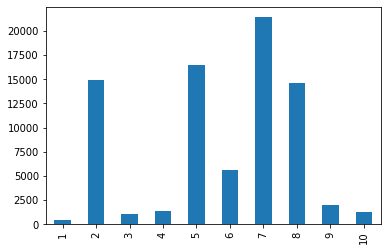

In [ ]:
# displays the distribution
data_merged['investor_country_round_index'].value_counts().sort_index().plot.bar()

<AxesSubplot:>

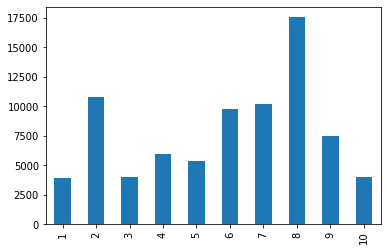

In [ ]:
# displays the distribution
data_merged['investors_round_index'].value_counts().sort_index().plot.bar()

In [ ]:
# drops these columns because they are now indices
del data_merged['investor_name'], data_merged['investor_country_code']

In [ ]:
# drop duplicates
data_merged.drop_duplicates(inplace=True)
data_merged.shape

(34297, 15)

## 4. Aggragating raised amount and index features by startup company and funding round
There might be more than one same round for a startup company (e.g. two seed rounds on different dates). An additional aggregation is required for raised amount and index features.

In [ ]:
# groupsby company_permalink and funding_round_type
agg_fields = ['raised_amount_usd', 'investors_round_index', 'investor_country_round_index']
agg_dict = { key: 'mean' for key in agg_fields}
agg_dict

{'raised_amount_usd': 'mean',
 'investors_round_index': 'mean',
 'investor_country_round_index': 'mean'}

In [ ]:
data_merged_grouped = (
    data_merged.groupby(["company_permalink", "funding_round"]).agg(agg_dict).round()
)
data_merged.drop(agg_fields, axis=1, inplace=True)

# merges back to the original dataframe
data_merged = data_merged.merge(
    data_merged_grouped,
    how="left",
    left_on=["company_permalink", "funding_round"],
    right_index=True,
)
for column in agg_fields:
    data_merged[column] = data_merged[column].astype(int)
data_merged.head(50)


,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funding_round,raised_amount_usd,investors_round_index,investor_country_round_index
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,venture A,2000000,8,7
2,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,NaN,2009-05-15,seed,500000,2,2
6,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/01c1aa44619ae45a16e3098fc73facfa,debt_financing,NaN,2013-04-08,debt_financing,647879,2,9
12,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/6aeb32ab3fc05db2b606d7a2466e8c09,venture,NaN,2014-01-15,venture,1682944,5,8
13,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/89317984885b44f02e4befb9dc2e588c,venture,NaN,2014-08-01,venture,1682944,5,8
14,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/fd1b3064232ba9b3cfb5653a619e82e8,venture,NaN,2011-04-05,venture,1682944,5,8
23,/organization/1001-menus,ZenChef,Local Businesses|Restaurants,FRA,A8,Paris,Paris,/funding-round/645b4cd895450b8e0268027cd7813047,venture,B,2015-11-04,venture B,6602694,6,5
26,/organization/1001-menus,ZenChef,Local Businesses|Restaurants,FRA,A8,Paris,Paris,/funding-round/8025123b90c1ab687f9857ffe18bfd3b,venture,A,2013-11-13,venture A,1768455,5,5
27,/organization/1001-menus,ZenChef,Local Businesses|Restaurants,FRA,A8,Paris,Paris,/funding-round/9d6619bf66478dd8bf19bfc8dc237770,seed,NaN,2012-12-27,seed,132169,2,2
28,/organization/1001-menus,ZenChef,Local Businesses|Restaurants,FRA,A8,Paris,Paris,/funding-round/b6c28ea4ebe32db7083052cf87e7c368,venture,A,2013-10-25,venture A,1768455,5,5


In [ ]:
# Dropping undisclosed and venture from funding_round

data_merged = data_merged[data_merged["funding_round"]!="undisclosed"]
data_merged = data_merged[data_merged["funding_round"]!="venture"]

In [ ]:
# delete unnecessary columns
data_merged.drop(
    ['funding_round_type' , 'funding_round_code'],
    axis = 1,
    inplace = True
)

In [ ]:
data_merged.drop_duplicates(inplace=True)

In [ ]:
data_merged.shape

(27639, 13)

## 5. Discretizing raised amount usd column in to buckets of 10

In [ ]:
funding_disc = pd.read_csv('params/funding_amount_discretization.csv')
funding_disc['1'] = funding_disc.shift(-1)
funding_disc = funding_disc.reset_index()
funding_disc['index'] = funding_disc['index'] + 1
funding_disc.loc[0,'0'] = 50000
funding_disc

,index,0,1
0,1,5.000000e+04,1.840000e+05
1,2,1.840000e+05,4.147046e+05
2,3,4.147046e+05,7.916469e+05
3,4,7.916469e+05,1.300000e+06
4,5,1.300000e+06,2.100000e+06
5,6,2.100000e+06,3.791804e+06
6,7,3.791804e+06,6.000000e+06
7,8,6.000000e+06,1.000000e+07
8,9,1.000000e+07,2.000000e+07
9,10,2.000000e+07,2.127194e+10


In [ ]:
# udf to be applied to df's rows
def disc(value):
    bucket = funding_disc[(value >= funding_disc['0']) & (value < funding_disc['1'])]['index'].values[0]
    return bucket

data_merged['raised_amount_buckets'] = data_merged['raised_amount_usd'].apply(disc)

## 6. Creating Rounds index feature

In [ ]:
data_merged['rounds_index'] = data_merged['funding_round'].apply(lambda x: rounds_index[x])

## 7. Creating Startup Company Country & Round index feature

In [ ]:
# There are null values in company_country_code column. To create the index feature
# first a temp df is created by removing the rows including null values. Then, index
# is created.

data_tmp = data_merged[['company_permalink', 'company_country_code', 'funding_round_permalink','funding_round']].copy()
print(data_tmp.shape)
data_tmp.dropna(subset= ['company_country_code'], inplace = True)
print(data_tmp.shape)

(27639, 4)
(26160, 4)


In [ ]:
# merge company_country_code with the dictionary from the json files, which will replace countries to "OTHER"
data_tmp.loc[:,'company_country_code'] = data_tmp['company_country_code'].apply(lambda x: startup_country_name_dict['company_country_name_new'][x])
data_tmp.head()

,company_permalink,company_country_code,funding_round_permalink,funding_round
0,/organization/0-6-com,CHN,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture A
2,/organization/1000-markets,USA,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed
6,/organization/1000museums-com,USA,/funding-round/01c1aa44619ae45a16e3098fc73facfa,debt_financing
23,/organization/1001-menus,FRA,/funding-round/645b4cd895450b8e0268027cd7813047,venture B
26,/organization/1001-menus,FRA,/funding-round/8025123b90c1ab687f9857ffe18bfd3b,venture A


In [ ]:
# Drop OTHER from company country code
data_tmp = data_tmp[data_tmp["company_country_code"]!="OTHER"]

In [ ]:
data_tmp

,company_permalink,company_country_code,funding_round_permalink,funding_round
0,/organization/0-6-com,CHN,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture A
2,/organization/1000-markets,USA,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed
6,/organization/1000museums-com,USA,/funding-round/01c1aa44619ae45a16e3098fc73facfa,debt_financing
23,/organization/1001-menus,FRA,/funding-round/645b4cd895450b8e0268027cd7813047,venture B
26,/organization/1001-menus,FRA,/funding-round/8025123b90c1ab687f9857ffe18bfd3b,venture A
...,...,...,...,...
113227,/organization/zyrra,USA,/funding-round/2a13fa52848ace2760b224a350a76b40,seed
113228,/organization/zyrra,USA,/funding-round/39baf35e59eb3efc5409cd4c5eaa50e1,seed
113230,/organization/zystor,USA,/funding-round/7ea37c0ff4132b084832039a9380d34e,venture A
113236,/organization/zytoprotec,AUT,/funding-round/0c43e717298296d2fb334fb236300f6e,venture A


In [ ]:
# first N items in dict
N = 5
{k: startup_country_round_index[k] for k in list(startup_country_round_index)[:N]}

{"('ARE', 'angel')": '1',
 "('ARE', 'convertible_note')": '1',
 "('ARE', 'grant')": '8',
 "('ARE', 'private_equity')": '10',
 "('ARE', 'seed')": '2'}

In [ ]:
# creates the index data frame from the dictionary from the json file
startup_country_round_index = pd.DataFrame.from_dict(startup_country_round_index, orient='index')

# calls the previously defined "parse_tuple" function to parse through 
startup_country_round_index.index = [parse_tuple(item) for item in list(startup_country_round_index.index)]


startup_country_round_index.index = pd.MultiIndex.from_tuples(startup_country_round_index.index)
startup_country_round_index.index.names = ['country', 'round']
print(startup_country_round_index)

                           0
country round               
ARE     angel              1
        convertible_note   1
        grant              8
        private_equity    10
        seed               2
...                       ..
USA     venture D          8
        venture E          9
        venture F          9
        venture G          9
        venture H          8

[475 rows x 1 columns]


In [ ]:
#since searching in dictionary objects are way faster, index df is converted to dict
startup_country_round_index_dict = startup_country_round_index.to_dict()[0]

In [ ]:
# udf to be applied to df's rows
def startup_country_rnd_idx(row):
    country = row['company_country_code']
    round_ = row['funding_round']

    search_key = tuple((country, round_))
    
    value = startup_country_round_index_dict[search_key]

    return int(value)
    
data_tmp['company_country_round_index'] = data_tmp.apply(startup_country_rnd_idx, axis = 1)
data_tmp['company_country_round_index'] = data_tmp['company_country_round_index'].astype(int)
data_tmp

,company_permalink,company_country_code,funding_round_permalink,funding_round,company_country_round_index
0,/organization/0-6-com,CHN,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture A,8
2,/organization/1000-markets,USA,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,seed,3
6,/organization/1000museums-com,USA,/funding-round/01c1aa44619ae45a16e3098fc73facfa,debt_financing,9
23,/organization/1001-menus,FRA,/funding-round/645b4cd895450b8e0268027cd7813047,venture B,6
26,/organization/1001-menus,FRA,/funding-round/8025123b90c1ab687f9857ffe18bfd3b,venture A,5
...,...,...,...,...,...
113227,/organization/zyrra,USA,/funding-round/2a13fa52848ace2760b224a350a76b40,seed,3
113228,/organization/zyrra,USA,/funding-round/39baf35e59eb3efc5409cd4c5eaa50e1,seed,3
113230,/organization/zystor,USA,/funding-round/7ea37c0ff4132b084832039a9380d34e,venture A,5
113236,/organization/zytoprotec,AUT,/funding-round/0c43e717298296d2fb334fb236300f6e,venture A,6


In [ ]:
data_tmp.drop(
    ['company_permalink', 'company_country_code', 'funding_round'],
    axis = 1,
    inplace = True
)
data_tmp.head()

,funding_round_permalink,company_country_round_index
0,/funding-round/5727accaeaa57461bd22a9bdd945382d,8
2,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,3
6,/funding-round/01c1aa44619ae45a16e3098fc73facfa,9
23,/funding-round/645b4cd895450b8e0268027cd7813047,6
26,/funding-round/8025123b90c1ab687f9857ffe18bfd3b,5


In [ ]:
data_merged = data_merged.merge(
    data_tmp,
    how = 'left',
    on = 'funding_round_permalink'
)
data_merged.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funded_at,funding_round,raised_amount_usd,investors_round_index,investor_country_round_index,raised_amount_buckets,rounds_index,company_country_round_index
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,2008-03-19,venture A,2000000,8,7,5,4,8.0
1,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,2009-05-15,seed,500000,2,2,3,1,3.0
2,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/01c1aa44619ae45a16e3098fc73facfa,2013-04-08,debt_financing,647879,2,9,3,6,9.0
3,/organization/1001-menus,ZenChef,Local Businesses|Restaurants,FRA,A8,Paris,Paris,/funding-round/645b4cd895450b8e0268027cd7813047,2015-11-04,venture B,6602694,6,5,8,5,6.0
4,/organization/1001-menus,ZenChef,Local Businesses|Restaurants,FRA,A8,Paris,Paris,/funding-round/8025123b90c1ab687f9857ffe18bfd3b,2013-11-13,venture A,1768455,5,5,5,4,5.0


Since there are missing startup countries in the dataset, related index values would also be null.
Following creates a regression model to predict missing values. Dependent variable is 'company_country_round_index', independent variables are "investors_round_index", "investor_country_round_index", "rounds_index".

In [ ]:
X = data_merged[data_merged['company_country_round_index'].notnull()][
    ["investors_round_index", "investor_country_round_index", "rounds_index"]
].copy()
y = data_merged[data_merged['company_country_round_index'].notnull()][
    'company_country_round_index'
]
mis_value_reg = LR().fit(X,y)

pickle.dump(mis_value_reg, open('model objects/comp_country_miss_imputer_model.pkl', 'wb'))

In [ ]:
data_merged["company_country_round_index_pred"] = mis_value_reg.predict(
    data_merged[
        ["investors_round_index", "investor_country_round_index", "rounds_index"]
    ]
)
data_merged[['company_country_round_index','company_country_round_index_pred']]

,company_country_round_index,company_country_round_index_pred
0,8.0,6.960108
1,3.0,2.767859
2,9.0,8.613706
3,6.0,5.573615
4,5.0,5.429270
...,...,...
27634,3.0,2.767859
27635,3.0,2.767859
27636,5.0,5.429270
27637,6.0,5.444354


Following block fills the missing 'company_country_round_index' values. If the index value is missing, then the predicted value is used to fill. If the predicted value is below 1, then it is set as 1. If the predicted value is greater than 10, it is set as 10. Otherwise, the actual prediction is used.

In [ ]:
def comp_cntry_rnd_idx_missing_imputer(row):

    value = row["company_country_round_index"]
    value_pred = round(row["company_country_round_index_pred"])

    if np.isnan(value):
        if value_pred < 1:
            return 1
        elif value_pred > 10:
            return 10
        else:
            return value_pred
    else:
        return value


data_merged["company_country_round_index"] = data_merged.apply(
    comp_cntry_rnd_idx_missing_imputer, axis=1
)


In [ ]:
data_merged["company_country_round_index"] = data_merged["company_country_round_index"].astype(int)
data_merged["rounds_index"] = data_merged["rounds_index"].astype(int)

## 8. Merge time features to the training dataset

In [ ]:
company_df = pd.read_csv('splitted data/companies_training.csv')
company_df = company_df[company_df['first_funding_at'].notna()]
company_df = company_df[company_df['founded_at'].notna()]

company_df['first_funding_at'] = pd.to_datetime(company_df['first_funding_at'], errors='coerce').dropna()
company_df['last_funding_at'] = pd.to_datetime(company_df['last_funding_at'], errors='coerce').dropna()
company_df['founded_at'] = pd.to_datetime(company_df['founded_at'], errors='coerce').dropna()

current_date = "2015-12-04"
company_df['time_since_first_investment'] = (pd.to_datetime(current_date) - company_df['first_funding_at']).astype('timedelta64[D]')
company_df['time_since_last_investment'] = (pd.to_datetime(current_date) - company_df['last_funding_at']).astype('timedelta64[D]')
company_df['company_age'] = (pd.to_datetime(current_date) - company_df['founded_at']).astype('timedelta64[D]')

investment_time_difference = company_df['time_since_first_investment'] - company_df['time_since_last_investment']
company_df['avg_time_between_rounds'] = investment_time_difference/company_df['funding_rounds']

company_df[['permalink','time_since_first_investment','time_since_last_investment','company_age','avg_time_between_rounds']]

,permalink,time_since_first_investment,time_since_last_investment,company_age,avg_time_between_rounds
2,/organization/0-6-com,2816.0,2816.0,3259.0,0.00
3,/organization/004-technologies,498.0,498.0,2163.0,0.00
4,/organization/1-2-3-listo,1019.0,1019.0,1433.0,0.00
6,/organization/1-618-technology,681.0,681.0,727.0,0.00
7,/organization/1-800-dentist,1933.0,1933.0,10929.0,0.00
...,...,...,...,...,...
53086,/organization/zynstra,1371.0,513.0,1465.0,214.50
53087,/organization/zyomyx-inc,2135.0,618.0,6546.0,379.25
53088,/organization/zypsee,861.0,800.0,1798.0,30.50
53089,/organization/zyraz-technology,2894.0,1022.0,8007.0,468.00


In [ ]:
time_feat_min_max = pd.DataFrame(columns=['feat', 'min', 'max'])

columns = ['time_since_first_investment','time_since_last_investment','company_age','avg_time_between_rounds']
for column in columns:
    min_val = company_df[column].min()
    max_val = company_df[column].max()
    d = {'feat' : column,
         'min'  : min_val,
         'max'  : max_val
    }
    time_feat_min_max = time_feat_min_max.append(d, ignore_index = True)

time_feat_min_max.set_index('feat', inplace = True)
time_feat_min_max.to_csv('params/time_feat_min_max.csv')

In [ ]:
data_merged = data_merged.merge(
    company_df, how="inner", left_on="company_permalink", right_on="permalink"
)

In [ ]:
"""
data_merged = data_merged[
    [
        "company_permalink",
        "funding_round",
        "investors_round_index",
        "investor_country_round_index",
        "rounds_index",
        "company_country_round_index",
        "time_since_first_investment",
        "time_since_last_investment",
        "company_age",
        "avg_time_between_rounds",
        "raised_amount_buckets",
    ]
].copy()
data_merged.drop_duplicates(inplace=True)
"""


'\ndata_merged = data_merged[\n    [\n        "company_permalink",\n        "funding_round",\n        "investors_round_index",\n        "investor_country_round_index",\n        "rounds_index",\n        "company_country_round_index",\n        "time_since_first_investment",\n        "time_since_last_investment",\n        "company_age",\n        "avg_time_between_rounds",\n        "raised_amount_buckets",\n    ]\n].copy()\ndata_merged.drop_duplicates(inplace=True)\n'

In [ ]:
#data_merged['time_since_first_investment'].hist(bins=200)

In [ ]:
columns = ['time_since_first_investment','time_since_last_investment','company_age','avg_time_between_rounds']
for column in columns:
    data_merged[column] = data_merged[column].apply(lambda x: 0 if x < 0 else x)

time_feat_min_max = pd.read_csv('params/time_feat_min_max.csv')
data_merged.describe()

,raised_amount_usd,investors_round_index,investor_country_round_index,raised_amount_buckets,rounds_index,company_country_round_index,company_country_round_index_pred,funding_rounds,time_since_first_investment,time_since_last_investment,company_age,avg_time_between_rounds
count,2.342900e+04,23429.000000,23429.000000,23429.000000,23429.000000,23429.000000,23429.000000,23429.000000,23427.000000,23429.000000,23429.000000,23427.000000
mean,1.490400e+07,5.601434,5.149985,6.602074,4.001750,5.535832,5.549976,3.478936,2114.451231,1026.194972,3063.191728,268.910172
std,6.592702e+07,2.830752,2.342795,2.775545,2.121873,2.105437,2.038155,2.301176,1350.561415,1080.456940,2618.098917,227.066735
min,5.000000e+04,1.000000,1.000000,1.000000,1.000000,1.000000,2.009983,1.000000,0.000000,0.000000,14.000000,0.000000
25%,1.300000e+06,3.000000,2.000000,5.000000,2.000000,3.000000,2.882035,2.000000,1012.000000,249.000000,1433.000000,106.500000
50%,5.000000e+06,6.000000,5.000000,7.000000,4.000000,5.000000,5.474523,3.000000,1827.000000,610.000000,2528.000000,248.000000
75%,1.300000e+07,8.000000,7.000000,9.000000,5.000000,7.000000,7.104452,5.000000,3126.000000,1433.000000,3989.000000,382.666667
max,4.700000e+09,10.000000,10.000000,10.000000,10.000000,10.000000,9.994215,19.000000,10564.000000,10564.000000,71194.000000,2583.000000


In [ ]:
lower = 1
upper = 10
for column in columns:
    min_val = time_feat_min_max[time_feat_min_max['feat'] == column]['min'].values[0]
    max_val = time_feat_min_max[time_feat_min_max['feat'] == column]['max'].values[0]

    data_merged[column] = round(((upper - lower) * ((data_merged[column] - min_val) / (max_val - min_val))) + lower)



In [ ]:
data_merged.dropna(inplace=True)

## 9. Creating Sector Round Index

In [ ]:
def drop_dupes(x):
    """this function removes duplicates"""
    return list(dict.fromkeys(x))

# reads the csv from the manually edited categories to sectors
categories = pd.read_csv("params/company_categories.csv", header=None)
# creates the dictionary from the csv
sectors = categories.set_index(0).to_dict()[1]

In [ ]:
rounds = pd.read_csv("splitted data/rounds_training.csv")

In [ ]:
# drops NaNs from the category list
rounds = rounds[rounds['company_category_list'].notna()]
# resets the index
rounds = rounds.reset_index(drop=True)
# new category list so it can be split
category_list = rounds['company_category_list']

In [ ]:
categories_list = category_list.tolist()
categories = []
for i in range(len(categories_list)):
    if "|" in str(categories_list[i]):
        categories.append(categories_list[i].split('|')) # splits the categories in that row 
    else:
        categories.append([categories_list[i]]) # makes sure that all the types are consistent, i.e. a list. 

In [ ]:
# drops the original category list
rounds.drop(columns='company_category_list',inplace=True)
# makes a new category list from the split one
rounds['company_category_list'] = categories

In [ ]:
# changes categories into sectors
company_sector = rounds['company_category_list'].apply(lambda x: [sectors[x[i]] for i in range(len(x))])

In [ ]:
# removes duplicates from the sectors
no_dupes_company_sector = company_sector.apply(lambda x: drop_dupes(x))

In [ ]:
# applies back the company sector list to the main dataframe
rounds['company_sector'] = no_dupes_company_sector

In [ ]:
sectors_list = no_dupes_company_sector

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
binarized_sectors = mlb.fit_transform(sectors_list) 
binarized_sectors_column_names = mlb.classes_

pickle.dump(mlb, open('model objects/sectors_binarizer.pkl', 'wb'))

overall_categories = pd.DataFrame(data=binarized_sectors,columns=binarized_sectors_column_names)
overall_categories

,Communication Services,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
88898,0,0,0,0,0,0,1,0,0,0,0
88899,0,0,0,0,0,0,1,0,0,0,0
88900,0,0,0,0,0,1,0,0,0,0,0
88901,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
final = pd.concat([rounds, overall_categories], axis=1)
final

,company_permalink,company_name,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,...,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Information Technology,Materials,Real Estate,Utilities
0,/organization/-fame,#fame,IND,16,Mumbai,Mumbai,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,2015-01-05,...,0,0,0,0,0,0,0,0,0,0
1,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",NaN,NaN,NaN,NaN,/funding-round/650b8f704416801069bb178a1418776b,venture,B,2014-01-30,...,1,0,0,0,0,0,1,0,0,0
2,/organization/0-6-com,0-6.com,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,...,0,0,0,0,0,0,1,0,0,0
3,/organization/004-technologies,004 Technologies,USA,IL,"Springfield, Illinois",Champaign,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,2014-07-24,...,0,0,0,0,0,0,1,0,0,0
4,/organization/1-2-3-listo,"1,2,3 Listo",CHL,12,Santiago,Las Condes,/funding-round/6de4609e894495105bc791ed64361288,seed,NaN,2013-02-18,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88898,/organization/zyrra,Zyrra,USA,MA,Boston,Cambridge,/funding-round/7a0fa791c96c9c447ee54662395beab9,venture,NaN,2012-10-18,...,0,0,0,0,0,1,0,0,0,0
88899,/organization/zyrra,Zyrra,USA,MA,Boston,Cambridge,/funding-round/cc8cd96a500332d5b4f4bcbddb306099,angel,NaN,2010-12-15,...,0,0,0,0,0,1,0,0,0,0
88900,/organization/zystor,Zystor,USA,WI,Milwaukee,Milwaukee,/funding-round/7ea37c0ff4132b084832039a9380d34e,venture,A,2004-12-16,...,0,0,0,0,1,0,0,0,0,0
88901,/organization/zytoprotec,Zytoprotec,AUT,3,Vienna,Gerasdorf Bei Wien,/funding-round/0c43e717298296d2fb334fb236300f6e,venture,A,2013-01-29,...,0,0,0,0,1,0,0,0,0,0


### 9.1. "Communication Services" round index

In [ ]:
with open('sectors json/sector_rounds_communication_services.json') as json_file:
    sector_rounds_communication_services_dict = json.load(json_file)

sector_rounds_communication_services_index = pd.DataFrame.from_dict(sector_rounds_communication_services_dict, orient='index')
sector_rounds_communication_services_index.index = [parse_tuple(item) for item in list(sector_rounds_communication_services_index.index)]

sector_rounds_communication_services_index.index = pd.MultiIndex.from_tuples(sector_rounds_communication_services_index.index)
sector_rounds_communication_services_index.index.names = ['communication_services', 'round']

sector_rounds_communication_services_index_dict = sector_rounds_communication_services_index.to_dict()[0]

def sec_rnd_communication_ix(row):
    sector = row['Communication Services']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_communication_services_index_dict[search_key]
        return int(value)

final['Communication_Services_round_index'] = final.apply(sec_rnd_communication_ix, axis=1)

### 9.2. "Consumer Discretionary" round index

In [ ]:
with open('sectors json/sector_rounds_consumer_discretionary.json') as json_file:
    sector_rounds_consumer_discretionary_dict = json.load(json_file)

sector_rounds_consumer_discretionary_index = pd.DataFrame.from_dict(sector_rounds_consumer_discretionary_dict, orient='index')
sector_rounds_consumer_discretionary_index.index = [parse_tuple(item) for item in list(sector_rounds_consumer_discretionary_index.index)]

sector_rounds_consumer_discretionary_index.index = pd.MultiIndex.from_tuples(sector_rounds_consumer_discretionary_index.index)
sector_rounds_consumer_discretionary_index.index.names = ['consumer_discretionary', 'round']

sector_rounds_consumer_discretionary_index_dict = sector_rounds_consumer_discretionary_index.to_dict()[0]

def sec_rnd_consumer_discretionary_ix(row):
    sector = row['Consumer Discretionary']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_consumer_discretionary_index_dict[search_key]
        return int(value)

final['Consumer_Discretionary_round_index'] = final.apply(sec_rnd_consumer_discretionary_ix, axis=1)

### 9.3. "Consumer Staples" round index

In [ ]:
with open('sectors json/sector_rounds_consumer_staples.json') as json_file:
    sector_rounds_consumer_staples_dict = json.load(json_file)

sector_rounds_consumer_staples_index = pd.DataFrame.from_dict(sector_rounds_consumer_staples_dict, orient='index')
sector_rounds_consumer_staples_index.index = [parse_tuple(item) for item in list(sector_rounds_consumer_staples_index.index)]

sector_rounds_consumer_staples_index.index = pd.MultiIndex.from_tuples(sector_rounds_consumer_staples_index.index)
sector_rounds_consumer_staples_index.index.names = ['consumer_staples', 'round']

sector_rounds_consumer_staples_index_dict = sector_rounds_consumer_staples_index.to_dict()[0]

def sec_rnd_consumer_staples_ix(row):
    sector = row['Consumer Staples']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_consumer_staples_index_dict[search_key]
        return int(value)

final['Consumer_Staples_round_index'] = final.apply(sec_rnd_consumer_staples_ix, axis=1)

### 9.4. "Energy" round index

In [ ]:
with open('sectors json/sector_rounds_energy.json') as json_file:
    sector_rounds_energy_dict = json.load(json_file)

sector_rounds_energy_index = pd.DataFrame.from_dict(sector_rounds_energy_dict, orient='index')
sector_rounds_energy_index.index = [parse_tuple(item) for item in list(sector_rounds_energy_index.index)]

sector_rounds_energy_index.index = pd.MultiIndex.from_tuples(sector_rounds_energy_index.index)
sector_rounds_energy_index.index.names = ['energy', 'round']

sector_rounds_energy_index_dict = sector_rounds_energy_index.to_dict()[0]

def sec_rnd_energy_ix(row):
    sector = row['Energy']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_energy_index_dict[search_key]
        return int(value)

final['Energy_round_index'] = final.apply(sec_rnd_energy_ix, axis=1)

### 9.5. "Financials" round index

In [ ]:
with open('sectors json/sector_rounds_financials.json') as json_file:
    sector_rounds_financials_dict = json.load(json_file)

sector_rounds_financials_index = pd.DataFrame.from_dict(sector_rounds_financials_dict, orient='index')
sector_rounds_financials_index.index = [parse_tuple(item) for item in list(sector_rounds_financials_index.index)]

sector_rounds_financials_index.index = pd.MultiIndex.from_tuples(sector_rounds_financials_index.index)
sector_rounds_financials_index.index.names = ['financials', 'round']

sector_rounds_financials_index_dict = sector_rounds_financials_index.to_dict()[0]

def sec_rnd_financials_ix(row):
    sector = row['Financials']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_financials_index_dict[search_key]
        return int(value)

final['Financials_round_index'] = final.apply(sec_rnd_financials_ix, axis=1)

### 9.6. "Health Care" round index

In [ ]:
with open('sectors json/sector_rounds_health_care.json') as json_file:
    sector_rounds_health_care_dict = json.load(json_file)

sector_rounds_health_care_index = pd.DataFrame.from_dict(sector_rounds_health_care_dict, orient='index')
sector_rounds_health_care_index.index = [parse_tuple(item) for item in list(sector_rounds_health_care_index.index)]

sector_rounds_health_care_index.index = pd.MultiIndex.from_tuples(sector_rounds_health_care_index.index)
sector_rounds_health_care_index.index.names = ['Health Care', 'round']

sector_rounds_health_care_index_dict = sector_rounds_health_care_index.to_dict()[0]

def sec_rnd_health_care_ix(row):
    sector = row['Health Care']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_health_care_index_dict[search_key]
        return int(value)

final['Health_Care_round_index'] = final.apply(sec_rnd_health_care_ix, axis=1)

### 9.7. "Industrials" round index

In [ ]:
with open('sectors json/sector_rounds_industrials.json') as json_file:
    sector_rounds_industrials_dict = json.load(json_file)

sector_rounds_industrials_index = pd.DataFrame.from_dict(sector_rounds_industrials_dict, orient='index')
sector_rounds_industrials_index.index = [parse_tuple(item) for item in list(sector_rounds_industrials_index.index)]

sector_rounds_industrials_index.index = pd.MultiIndex.from_tuples(sector_rounds_industrials_index.index)
sector_rounds_industrials_index.index.names = ['Industrials', 'round']

sector_rounds_industrials_index_dict = sector_rounds_industrials_index.to_dict()[0]

def sec_rnd_industrials_ix(row):
    sector = row['Industrials']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_industrials_index_dict[search_key]
        return int(value)

final['Industrials_round_index'] = final.apply(sec_rnd_industrials_ix, axis=1)

### 9.8. "Information Technology" round index

In [ ]:
with open('sectors json/sector_rounds_information_technology.json') as json_file:
    sector_rounds_information_technology_dict = json.load(json_file)

sector_rounds_information_technology_index = pd.DataFrame.from_dict(sector_rounds_information_technology_dict, orient='index')
sector_rounds_information_technology_index.index = [parse_tuple(item) for item in list(sector_rounds_industrials_index.index)]

sector_rounds_information_technology_index.index = pd.MultiIndex.from_tuples(sector_rounds_information_technology_index.index)
sector_rounds_information_technology_index.index.names = ['Information Technology', 'round']

sector_rounds_information_technology_index_dict = sector_rounds_information_technology_index.to_dict()[0]

def sec_rnd_information_technology_ix(row):
    sector = row['Information Technology']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_information_technology_index_dict[search_key]
        return int(value)

final['Information_Technology_round_index'] = final.apply(sec_rnd_information_technology_ix, axis=1)

### 9.9. "Materials" round index

In [ ]:
with open('sectors json/sector_rounds_materials.json') as json_file:
    sector_rounds_materials_dict = json.load(json_file)

sector_rounds_materials_index = pd.DataFrame.from_dict(sector_rounds_materials_dict, orient='index')
sector_rounds_materials_index.index = [parse_tuple(item) for item in list(sector_rounds_materials_index.index)]

sector_rounds_materials_index.index = pd.MultiIndex.from_tuples(sector_rounds_materials_index.index)
sector_rounds_materials_index.index.names = ['Materials', 'round']

sector_rounds_materials_index_dict = sector_rounds_materials_index.to_dict()[0]

def sec_rnd_materials_ix(row):
    sector = row['Materials']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_materials_index_dict[search_key]
        return int(value)

final['Materials_round_index'] = final.apply(sec_rnd_materials_ix, axis=1)

### 9.10. "Real Estate" round index 

In [ ]:
with open('sectors json/sector_rounds_real_estate.json') as json_file:
    sector_rounds_real_estate_dict = json.load(json_file)

sector_rounds_real_estate_index = pd.DataFrame.from_dict(sector_rounds_real_estate_dict, orient='index')
sector_rounds_real_estate_index.index = [parse_tuple(item) for item in list(sector_rounds_real_estate_index.index)]

sector_rounds_real_estate_index.index = pd.MultiIndex.from_tuples(sector_rounds_real_estate_index.index)
sector_rounds_real_estate_index.index.names = ['Real Estate', 'round']

sector_rounds_real_estate_index_dict = sector_rounds_real_estate_index.to_dict()[0]

def sec_rnd_real_estate_ix(row):
    sector = row['Real Estate']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_real_estate_index_dict[search_key]
        return int(value)

final['Real_Estate_round_index'] = final.apply(sec_rnd_real_estate_ix, axis=1)

### 9.11. "Utilities" round index

In [ ]:
with open('sectors json/sector_rounds_utilities.json') as json_file:
    sector_rounds_utilities_dict = json.load(json_file)

sector_rounds_utilities_index = pd.DataFrame.from_dict(sector_rounds_utilities_dict, orient='index')
sector_rounds_utilities_index.index = [parse_tuple(item) for item in list(sector_rounds_utilities_index.index)]

sector_rounds_utilities_index.index = pd.MultiIndex.from_tuples(sector_rounds_utilities_index.index)
sector_rounds_utilities_index.index.names = ['Utilities', 'round']

sector_rounds_utilities_index_dict = sector_rounds_utilities_index.to_dict()[0]

def sec_rnd_utilities_ix(row):
    sector = row['Utilities']
    comm_round = row['funding_round']

    if sector == 0:
        return int(0)
    else:
        search_key = tuple((sector, comm_round))
        value = sector_rounds_real_estate_index_dict[search_key]
        return int(value)

final['Utilities_round_index'] = final.apply(sec_rnd_utilities_ix, axis=1)

In [ ]:
final

,company_permalink,company_name,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,...,Consumer_Discretionary_round_index,Consumer_Staples_round_index,Energy_round_index,Financials_round_index,Health_Care_round_index,Industrials_round_index,Information_Technology_round_index,Materials_round_index,Real_Estate_round_index,Utilities_round_index
0,/organization/-fame,#fame,IND,16,Mumbai,Mumbai,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,2015-01-05,...,0,0,0,0,0,0,0,0,0,0
1,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",NaN,NaN,NaN,NaN,/funding-round/650b8f704416801069bb178a1418776b,venture,B,2014-01-30,...,6,0,0,0,0,0,5,0,0,0
2,/organization/0-6-com,0-6.com,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,...,0,0,0,0,0,0,4,0,0,0
3,/organization/004-technologies,004 Technologies,USA,IL,"Springfield, Illinois",Champaign,/funding-round/1278dd4e6a37fa4b7d7e06c21b3c1830,venture,NaN,2014-07-24,...,0,0,0,0,0,0,5,0,0,0
4,/organization/1-2-3-listo,"1,2,3 Listo",CHL,12,Santiago,Las Condes,/funding-round/6de4609e894495105bc791ed64361288,seed,NaN,2013-02-18,...,0,0,0,0,0,2,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88898,/organization/zyrra,Zyrra,USA,MA,Boston,Cambridge,/funding-round/7a0fa791c96c9c447ee54662395beab9,venture,NaN,2012-10-18,...,0,0,0,0,0,4,0,0,0,0
88899,/organization/zyrra,Zyrra,USA,MA,Boston,Cambridge,/funding-round/cc8cd96a500332d5b4f4bcbddb306099,angel,NaN,2010-12-15,...,0,0,0,0,0,2,0,0,0,0
88900,/organization/zystor,Zystor,USA,WI,Milwaukee,Milwaukee,/funding-round/7ea37c0ff4132b084832039a9380d34e,venture,A,2004-12-16,...,0,0,0,0,5,0,0,0,0,0
88901,/organization/zytoprotec,Zytoprotec,AUT,3,Vienna,Gerasdorf Bei Wien,/funding-round/0c43e717298296d2fb334fb236300f6e,venture,A,2013-01-29,...,0,0,0,0,5,0,0,0,0,0


In [ ]:
final = final.loc[:,['funding_round_permalink','Communication_Services_round_index',
       'Consumer_Discretionary_round_index', 'Consumer_Staples_round_index',
       'Energy_round_index', 'Financials_round_index',
       'Health_Care_round_index', 'Industrials_round_index',
       'Information_Technology_round_index', 'Materials_round_index',
       'Real_Estate_round_index', 'Utilities_round_index']]


In [ ]:
# Merging sectors round indexes with the main dataframe
data_merged_final = data_merged.merge(final, how = 'left', on = 'funding_round_permalink')
data_merged_final.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funded_at,funding_round,...,Consumer_Discretionary_round_index,Consumer_Staples_round_index,Energy_round_index,Financials_round_index,Health_Care_round_index,Industrials_round_index,Information_Technology_round_index,Materials_round_index,Real_Estate_round_index,Utilities_round_index
0,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,2008-03-19,venture A,...,0,0,0,0,0,0,4,0,0,0
1,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,USA,WA,Seattle,Seattle,/funding-round/ce6749b6441f52ccaf38b6d5578779fd,2009-05-15,seed,...,1,0,0,0,0,2,0,0,0,0
2,/organization/1000museums-com,1000museums.com,Curated Web,USA,MA,MA - Other,Lenox,/funding-round/01c1aa44619ae45a16e3098fc73facfa,2013-04-08,debt_financing,...,0,0,0,0,0,0,6,0,0,0
3,/organization/1001-menus,ZenChef,Local Businesses|Restaurants,FRA,A8,Paris,Paris,/funding-round/645b4cd895450b8e0268027cd7813047,2015-11-04,venture B,...,6,0,0,5,0,0,0,0,0,0
4,/organization/1001-menus,ZenChef,Local Businesses|Restaurants,FRA,A8,Paris,Paris,/funding-round/8025123b90c1ab687f9857ffe18bfd3b,2013-11-13,venture A,...,4,0,0,4,0,0,0,0,0,0


In [ ]:
# Removing certain funding round types
print('Shape Before: ', data_merged_final.shape)
data_merged_final = data_merged_final[data_merged_final['funding_round'] != 'debt_financing']
data_merged_final = data_merged_final[data_merged_final['funding_round'] != 'grant']
data_merged_final = data_merged_final[data_merged_final['funding_round'] != 'convertible_note']
data_merged_final = data_merged_final[data_merged_final['funding_round'] != 'non_equity_assistance']
print('Shape After: ', data_merged_final.shape)

Shape Before:  (21729, 46)
Shape After:  (20497, 46)


## 10. Modelling experimentation

First Evaluation - Linear Regression, Naive Bayes, and Support Vector Regression

In [ ]:
X = data_merged_final[
    ["investors_round_index",
    "investor_country_round_index", "rounds_index", "company_country_round_index",
     'time_since_first_investment','time_since_last_investment','company_age','avg_time_between_rounds',
       'Communication_Services_round_index',
       'Consumer_Discretionary_round_index', 'Consumer_Staples_round_index',
       'Energy_round_index', 'Financials_round_index',
       'Health_Care_round_index', 'Industrials_round_index',
       'Information_Technology_round_index', 'Materials_round_index',
       'Real_Estate_round_index', 'Utilities_round_index']
].copy()

for column in X.columns:
    X[column] = X[column].astype(int)

y = data_merged_final[
    'raised_amount_buckets'
]

reg = LR().fit(X,y)
naive_bayes = CatNB().fit(X,y)
svr = SVR().fit(X,y)

y_hat_reg = reg.predict(X)
y_hat_nb = naive_bayes.predict(X)
y_hat_svr = svr.predict(X)

pickle.dump(reg, open('model objects/regression_predictor_model.pkl', 'wb'))
pickle.dump(naive_bayes, open('model objects/naive_bayes_predictor_model.pkl', 'wb'))
pickle.dump(svr, open('model objects/support_vect_predictor_model.pkl', 'wb'))

In [ ]:
print('Training evaluation:')
print(
    "Regr. r2:",
    round(r2_score(y, y_hat_reg),2),
    "Regr. RMSE:",
    round(pow(mean_squared_error(y, y_hat_reg), 0.5),2),
)
print(
    "Naive Bayes. r2:",
    round(r2_score(y, y_hat_nb),2),
    "Naive Bayes RMSE:",
    round(pow(mean_squared_error(y, y_hat_nb), 0.5),2),
)
print(
    "SVR. r2:",
    round(r2_score(y, y_hat_svr),2),
    "SVR RMSE:",
    round(pow(mean_squared_error(y, y_hat_svr), 0.5),2),
)


Training evaluation:
Regr. r2: 0.76 Regr. RMSE: 1.33
Naive Bayes. r2: 0.62 Naive Bayes RMSE: 1.67
SVR. r2: 0.78 SVR RMSE: 1.27


Second Evaluation - Hyperparameter Tuning using GridSearch

In [ ]:
param = {'max_depth' : [5,10,25],
        'min_samples_split' : [5,10,50],
        'min_samples_leaf' : [5,10,50],
        'max_leaf_nodes' : [5000,1000,100],
        'min_impurity_decrease' : [0.001, 0.01, 0.05],
        'ccp_alpha' : [0.001,0.01,0.05]} 

dec_tree = DTR()

grids = GridSearchCV(dec_tree,param, scoring= 'neg_root_mean_squared_error', cv = 3, n_jobs = -1, verbose = 2000, pre_dispatch = 4)

grids.fit(X,np.ravel(y))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits


GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.001, 0.01, 0.05],
                         'max_depth': [5, 10, 25],
                         'max_leaf_nodes': [5000, 1000, 100],
                         'min_impurity_decrease': [0.001, 0.01, 0.05],
                         'min_samples_leaf': [5, 10, 50],
                         'min_samples_split': [5, 10, 50]},
             pre_dispatch=4, scoring='neg_root_mean_squared_error',
             verbose=2000)

In [ ]:
best_model = grids.best_estimator_

In [ ]:
pickle.dump(best_model, open('model objects/decision_tree_model_best.pkl', 'wb'))

from sklearn.model_selection import GridSearchCV

param = {'kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),'C' :
        [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')}

modelsvr = SVR()

grids = GridSearchCV(modelsvr,param, cv = 3, n_jobs = -1, verbose = 2)

grids.fit(X,y)

In [ ]:
grids

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.001, 0.01, 0.05],
                         'max_depth': [5, 10, 25],
                         'max_leaf_nodes': [5000, 1000, 100],
                         'min_impurity_decrease': [0.001, 0.01, 0.05],
                         'min_samples_leaf': [5, 10, 50],
                         'min_samples_split': [5, 10, 50]},
             pre_dispatch=4, scoring='neg_root_mean_squared_error',
             verbose=2000)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f906c6b7-4fb3-42a0-9ffa-f1056dea520e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>